# INITIALIZATION

In [1]:
%matplotlib inline

!pip install -q dill
!pip install -q mlxtend
!pip install -q SALib
!pip install -q pydoe

from functools import reduce
from matplotlib import cm
from mlxtend.regressor import StackingRegressor, StackingCVRegressor
from mpl_toolkits.mplot3d import axes3d, Axes3D
from pyDOE import lhs
from scipy.interpolate import griddata
from scipy.stats import median_test
from sklearn.base import clone
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import scipy.stats  as stats
import seaborn as sns
import time
import warnings

%matplotlib inline 

warnings.filterwarnings('ignore')

# Auxiliary funtion - Translates parameters from its original name to the
#                    required form in the StackedRegressor model
def forStack(model, orig_params):
  ans = {}
  for key,value in orig_params.items():
    ans[model+'__'+key] = value
  return ans

# Default parameters
SMP = dict()
PARS = dict()
PARS['def_gauss'] = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) #+ WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
MODS = dict() 
lcvgrid = []
MODS_NAMES = {'lr':"Linear Reg", \
              'svr_l':"SVR Linear", \
              'svr_r':"SVR RBF", \
              'nn':"MLP", \
              'rf':"Random Forest", \
              'gb':"Gradient Boosting", \
              'xgb':"X-Gradient Boosting", \
              'gp':"Gaussian Process", \
              'l_mr':"Linear MR", \
              'sl_mr':"Stacked Linear MR"}
# Full
#KEYS = ['lr','svr_l','svr_r','nn','rf','gb','xgb','gp','l_mr','sl_mr']
# Selection
KEYS = ['rf','gb','xgb','sl_mr']

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Plot styling
plt.rcParams['axes.facecolor'] = "1.0"
plt.rcParams['axes.edgecolor'] = "222"
plt.rcParams['grid.color'] = "0.3"
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.linewidth'] = 1

# TEST FUNCTIONS

## Rosenbrock _dim_-D
*(Rosenbrock 1960)*

In [3]:
def use_rosenbrock(dim): 
  global SMP
  global PARS
  # Generating a sample dataset - Using analytical function Rosenbrock (1960) - https://es.wikipedia.org/wiki/Funci%C3%B3n_de_Rosenbrock
  if dim == None: 
    dim = 4
  a, b = 1, 100
  if dim > 2:
    def Ros(X):
      ans = 0
      for i in range(1, int(dim/2)):
        ans += b*(X[:,(2*i-1)-1]**2 - X[:,(2*i)-1])**2 + (X[:,(2*i-1)-1] - 1)**2  
      return ans
  else:
    Ros = lambda X: 100*(X[:,0]**2 - X[:,1])**2 + (X[:,0] - 1)**2  
  tr_dim = 10*(dim)
  te_dim = 100*(dim)
  X = np.array(lhs(dim,samples=tr_dim)) * 4 - 2
  y = Ros(X)
  Xtest = np.array(lhs(dim,samples=te_dim)) * 4 - 2
  ytest = Ros(Xtest)
  SMP = {'case': "Rosenbrock %dD"%(dim), 'X': X, 'y': y, 'Xtest': Xtest, 'ytest': ytest }
  (sample_size, dim) = X.shape
  # Parameters for GridSearchCV
  #Ccm =  1817.308,  ecm =   578.451
  PARS['svr_l']    = {'C': [2500.0, 3000.0, 3500.0], 'degree': [2, 3]}
  PARS['svr_r']    = {'C': [900.0, 1800.0, 3600.0], 'gamma': [0.10, 0.125, 0.15]}
  PARS['nn']       = {'hidden_layer_sizes':[math.floor(sample_size/(dim+1)*X) for X in [0.50, 0.75, 1.0]], 'activation':['logistic'], } # #neuronas acordes a 100%, 75% y 50% del tamaño muestral
  PARS['rf']       = {'n_estimators':[25, 50, 75], 'max_features':[None, 'sqrt'], 'max_depth':[2, 3]}
  PARS['gb']       = {'learning_rate':[0.05,0.1],'n_estimators':[50, 75, 100], 'subsample': [0.3, 0.5, 1.0], 'max_features':['sqrt', 1.0], 'max_depth':[2,3,4]}
  PARS['xgb']      = {'learning_rate':[0.05,0.1],'n_estimators':[50, 75, 100], 'subsample': [0.3, 0.5, 1.0], 'colsample_bytree':[0.75, 1.0], 'max_depth':[2, 3]}
  PARS['mr_svr_r'] = {'meta-svr__C': [25.0, 30.0, 35.0], 'meta-svr__gamma': [0.0001, 0.001, 0.01]}
  PARS['gp']       = {'kernel': [PARS['def_gauss']], 'alpha':[0.5], 'n_restarts_optimizer':[4]}

# MODELS BUILDING

## Individual models training

In [4]:
def train_ind(MODS):
  
  #Cleaning MODS
  ind_keys = ['lr', 'svr_l', 'svr_r', 'nn', 'rf', 'gb', 'xgb', 'gp']
  for cur_k in ind_keys:
    MODS.pop(cur_k, None)
  
  # Individual model train
  if 'lr' in KEYS:    MODS['lr']    = LinearRegression()
  if 'svr_l' in KEYS: MODS['svr_l'] = GridSearchCV(estimator=SVR(kernel='poly'), param_grid=PARS['svr_l'], cv=5, refit=True)
  if 'svr_r' in KEYS: MODS['svr_r'] = GridSearchCV(estimator=SVR(kernel='rbf'), param_grid=PARS['svr_r'], cv=5, refit=True)
  if 'nn' in KEYS:    MODS['nn']    = GridSearchCV(estimator=MLPRegressor(solver='lbfgs'), param_grid=PARS['nn'], cv=5, refit=True)
  if 'rf' in KEYS:    MODS['rf']    = GridSearchCV(estimator=RandomForestRegressor(), param_grid=PARS['rf'], cv=5, refit=True)
  if 'gb' in KEYS:    MODS['gb']    = GridSearchCV(estimator=GradientBoostingRegressor(random_state=cur_seed), param_grid=PARS['gb'], cv=5, refit=True)
  if 'xgb' in KEYS:   MODS['xgb']   = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=PARS['xgb'], cv=5, refit=True)
  if 'gp' in KEYS:    MODS['gp']    = GridSearchCV(estimator=GaussianProcessRegressor(PARS['def_gauss']), param_grid=PARS['gp'], cv=5, refit=True)

  for mod in MODS.values():
    getattr(mod, 'fit')(SMP['X'], SMP['y'])

## Linear meta-regressor

In [5]:
def train_lin(MODS):
  if not 'l_mr' in KEYS: return
  
  # Ensemble definition
  stregr = StackingRegressor(regressors=[SVR(kernel='rbf'), LinearRegression(), MLPRegressor(solver='lbfgs')], \
                             meta_regressor=LinearRegression(fit_intercept=False))
  # Training the stacking classifier
  params = { }
  params.update(forStack('svr',PARS['svr_r']))
  params.update(forStack('mlpregressor',PARS['nn']))
  lgrid = GridSearchCV(estimator=stregr, param_grid=params, cv=5, refit=True)
  lgrid.fit(SMP['X'], SMP['y'])

  MODS['l_mr'] = lgrid.best_estimator_

## Linear Stacked regressor

In [6]:
def train_sta(MODS):
  if not 'sl_mr' in KEYS: return
  
  # Ensemble definition
  stregr = StackingCVRegressor(regressors=[SVR(kernel='rbf'), LinearRegression(), MLPRegressor(solver='lbfgs'), \
                               GaussianProcessRegressor(alpha=0.5)], \
                               meta_regressor=LinearRegression(fit_intercept=False))
  # Training the stacking classifier
  params = { }
  params.update(forStack('svr',PARS['svr_r']))
  params.update(forStack('mlpregressor',PARS['nn']))
  params.update(forStack('gaussianprocessregressor',PARS['gp']))
  lcvgrid = GridSearchCV(estimator=stregr, param_grid=params, cv=5, refit=True, scoring='neg_mean_squared_error')
  lcvgrid.fit(SMP['X'], SMP['y'])

  MODS['sl_mr'] = lcvgrid.best_estimator_

## Non-linear meta-regressors

In [7]:
# Ensemble definition
#stregr = StackingRegressor(regressors=[svr_rbf, lr, nn], meta_regressor=svr_rbf)

# Training the stacking classifier
#params = { }
#params.update(forStack('svr',svr_r_params))
#params.update(forStack('mlpregressor',nn_params))
#params.update(mr_svr_r_params)
#nlgrid = GridSearchCV(estimator=stregr, param_grid=params, cv=5, refit=True)
#nlgrid.fit(X, y)
#nl_ens = nlgrid.best_estimator_

In [8]:
# Ensemble definition
#stregr = StackingRegressor(regressors=[svr_rbf, lr, nn], meta_regressor=grad_boost)

# Training the stacking classifier
#params = { }
#params.update(forStack('svr',svr_r_params))
#nl2grid = GridSearchCV(estimator=stregr, param_grid=params, cv=5, refit=True)
#nl2grid.fit(X, y)
#nl2_ens = nl2grid.best_estimator_

# AUXILIARY FUNCTIONS

## Nestimators sensivity

In [9]:
def nestimators_sens(params, seed):
  m = [10, 20, 50, 75, 100, 125, 150, 200]
  residuals = pd.DataFrame()
  for cur_m in m:  
    stage_gb = GradientBoostingRegressor(learning_rate=params['learning_rate'],
                                         n_estimators=cur_m,
                                         subsample=params['subsample'], 
                                         max_features=params['max_features'],
                                         max_depth=params['max_depth'])
    stage_gb.fit(SMP['X'], SMP['y'])
    residuals = residuals.append(pd.DataFrame({'Nestimators': cur_m, 'MSE': mean_squared_error(SMP['ytest'], stage_gb.predict(SMP['Xtest']))}, index=[seed]))    
  return residuals

## Performance measures calculation

In [10]:
def evaluate(MODS, muted=True):
  ## Performance indicators
  answer = { 'Method':[MODS_NAMES[cur] for cur in KEYS] }  
  answer['R2']    = [MODS[cur].score(SMP['X'], SMP['y']) for cur in KEYS]
  answer['MSEtr'] = [ mean_squared_error(SMP['y'], MODS[cur].predict(SMP['X'])) for cur in KEYS]
  answer['MSEte'] = [ mean_squared_error(SMP['ytest'], MODS[cur].predict(SMP['Xtest'])) for cur in KEYS]
  
  tempo = pd.DataFrame(answer).ix[:,['Method', 'R2', 'MSEtr', 'MSEte']]
  if not muted:
    print("Resultados para el caso\n**** %s ****\n" % (SMP['case']))
    print("%25s\t%10s\t%10s\t%10s" % ("Ensemble", "Score (R2)", "MSE(train)", "MSE(test)"))
    for index, row in tempo.iterrows():
      print("%25s\t%10.3f\t%10.3f\t%10.3f" % (row['Method'], row['R2'], row['MSEtr'], row['MSEte']))

    print("\nParámetros de interés")
    if 'lr' in KEYS:    print("%25s\t%s" % ("Linear Reg", MODS['lr'].coef_)) 
    if 'svr_l' in KEYS: print("%25s\t%s" % ("SVR Linear", MODS['svr_l'].best_params_)) 
    if 'svr_r' in KEYS: print("%25s\t%s" % ("SVR RBF", MODS['svr_r'].best_params_)) 
    if 'nn' in KEYS:    print("%25s\t%s" % ("MLP", MODS['nn'].best_params_)) 
    if 'rf' in KEYS:    print("%25s\t%s" % ("Random Forest", MODS['rf'].best_params_)) 
    if 'gb' in KEYS:    print("%25s\t%s" % ("Gradient Boosting",  MODS['gb'].best_params_)) 
    if 'xgb' in KEYS:   print("%25s\t%s" % ("X-Gradient Boosting",  MODS['xgb'].best_params_)) 
    if 'gp' in KEYS:    print("%25s\t%s" % ("Gaussian Process", "Kern: %s - alpha: %s"%(MODS['gp'].kernel_, np.mean(MODS['gp'].alpha_))))
    if 'l_mr' in KEYS:  print("%25s\t%s" % ("Linear MR", "Coefs: %s - %s"%([i for i in MODS['l_mr'].named_regressors.keys()], MODS['l_mr'].coef_)))  
    if 'sl_mr' in KEYS: print("%25s\t%s" % ("Stacked Linear MR", "Coefs: %s - %s"%([i for i in MODS['sl_mr'].named_regressors.keys()], MODS['sl_mr'].meta_regr_.coef_)))
  
  
  return tempo

# MAIN PROGRAM

## Cherkassky & Ma - C Hyperparameter approximation

In [11]:
# Target function
#use_h4()

# Hyper parameter identification
#C = max(abs(np.mean(SMP['y']) + np.std(SMP['y'])), abs(np.mean(SMP['y']) - np.std(SMP['y'])))
#print ("Ccm = %9.3f"%(C))
#from sklearn.neighbors import KNeighborsRegressor
#neigh = KNeighborsRegressor(n_neighbors=6)
#neigh.fit(SMP['X'],SMP['y'])
#noise_var = 6/5*mean_squared_error(SMP['y'],neigh.predict(SMP['X']))
#ecm = 3*np.sqrt(noise_var*np.log(len(SMP['y']))/len(SMP['y']))
#print("ecm = %9.3f"%ecm)
#model = GridSearchCV(estimator=SVR(kernel='rbf'), param_grid=PARS['svr_r'], cv=5, refit=True)
#model.fit(SMP['X'], SMP['y'])

# Grid performance evaluation
#for idx in range(len(model.cv_results_['mean_test_score'])):
#  print("Model %2d: %0.3f +/- %0.2f %r %s" % (idx, 
#                                model.cv_results_['mean_test_score'][idx], 
#                                model.cv_results_['std_test_score'][idx] / 2.0, 
#                                model.cv_results_['params'][idx],
#                                ("","<-- best")[idx == model.best_index_]))

## Main program - alterno


In [12]:
## get performance measures for several seeds
PARS['def_gauss'] = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-3, 1e2)) #\
    #+ WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
KEYS = ['gb','sl_mr']
np.random.seed(1)
use_rosenbrock(6)           # Target test function (update also in line 17 and 31)
boots  = 150                # Number of boots
tr_dim = len(SMP['ytest'])

# Predefined seeds (np.random.randint(10000, size=boots))
seeds = np.asarray([1036, 1050, 1063, 1102, 136, 1452, 1461, 1490, 1495, 1532, 1571, 
                    16, 1702, 1764, 1942, 2053, 2082, 2244, 2295, 2333, 2341, 2352, 
                    2374, 2413, 2489, 2494, 2576, 2683, 2823, 284, 2929, 309, 3237, 
                    3255, 327, 3275, 3297, 3324, 3327, 34, 3479, 3583, 3584, 3620, 367, 
                    3684, 3707, 3714, 3724, 3727, 376, 3786, 3840, 3896, 3942, 4037, 
                    4212, 4265, 4404, 4411, 4454, 4465, 4562, 4616, 4630, 4942, 4951, 
                    4958, 509, 5127, 5137, 5228, 526, 5305, 5323, 5359, 5382, 5402, 5429, 
                    5438, 558, 5650, 570, 5817, 5820, 5842, 5854, 5858, 5934, 5969, 6001, 
                    6110, 6125, 6130, 6146, 6258, 6292, 630, 6340, 6390, 6447, 645, 6461, 
                    6582, 6627, 6657, 67, 6778, 6871, 6886, 7048, 7082, 7097, 712, 7128, 
                    7143, 7164, 7173, 7318, 7427, 7482, 7527, 7571, 7732, 7821, 7900, 
                    7911, 7950, 8081, 8223, 8519, 8806, 8859, 8977, 9121, 9227, 9273, 
                    9293, 9308, 9535, 954, 9541, 9544, 9555, 9582, 9600, 9856, 9885, 
                    9919, 2403]) 
start_time = time.time()
idx = 0

# Reading available files on disk
file_list = [f for f in os.listdir('.') if os.path.isfile(f)]

for cur_seed in seeds:     # For 1 cycle evaluation (toggle lines 15-16, 22-23, 86-90)
#def proceso(cur_seed):
  filename = '181120_rosenbrock6D_10dim_{}boots_curseed_{}.pkl'.format(boots,cur_seed)
  test = [ X for X in file_list if X == filename ]  # Get already simulated seeds
  if len(test) > 0:
    # Seed already simulated. Skip to next cycle.
    print('[%s]Lista semilla %d!'% (time.strftime("%H:%M:%S", time.gmtime(time.time()-start_time)),cur_seed))
    #return {'seed':-1, 'MSErr':[], 'cur_errors':[], 'freqs':[], 'weights':[]}
    continue
  MODS = {}                # Models keeping
  global PARS              # Case study train/test datasets
  freqs = np.zeros((2,6))  # 2 methods (GB, ST),6 Indicators (MSEtr, MSEte, max_features, sub_sampling, n_estimators, max_depth)
  np.random.seed(cur_seed)
  
  # Loading train and test sets
  print("[{}]Loading data (seed:{})... ".format(time.strftime("%H:%M:%S", time.gmtime(time.time()-start_time)), cur_seed))
  use_rosenbrock(6)
  
  # Train individual models
  print("[{}]Training individual regressors...".format(time.strftime("%H:%M:%S", time.gmtime(time.time()-start_time))))
  train_ind(MODS)
  
  # Train linear ensemble
  np.random.seed(cur_seed)
  print("[{}]Training linear MR...".format(time.strftime("%H:%M:%S", time.gmtime(time.time()-start_time))))
  train_lin(MODS)
  
  # Train stacked ensemble
  np.random.seed(cur_seed)
  print("[{}]Training stacked MR... ".format(time.strftime("%H:%M:%S", time.gmtime(time.time()-start_time))))
  train_sta(MODS)
  
  # Number of estimators sensitivity
  MSErr = nestimators_sens(MODS['gb'].best_params_, cur_seed)
  
  # Calculate and print performance measures
  cur_errors = evaluate(MODS, False)
  datos = {'seed':cur_seed } # Gathering data to dump on disk
  freqs[:,0] = cur_errors['MSEtr']                      # Registering MSE training
  freqs[:,1] = cur_errors['MSEte']                      # Registering MSE testing
  tmp = MODS['gb'].best_params_['max_features']         
  freqs[0,2] = 0.5 if tmp=='sqrt' else tmp              # Registering max_features (0.5 = 'sqrt')
  freqs[0,3] = MODS['gb'].best_params_['subsample']     # Registering sub_sampling
  freqs[0,4] = MODS['gb'].best_params_['n_estimators']  # Registering n_estimators
  freqs[0,5] = MODS['gb'].best_params_['max_depth']     # Registering max_depth
  weights = MODS['sl_mr'].meta_regr_.coef_              # Registering Stack coefficients
  
  print('[%s]Lista semilla %d!'% (time.strftime("%H:%M:%S", time.gmtime(time.time()-start_time)),cur_seed), end='')
  print('Van %d de %d.' % (seeds.tolist().index(cur_seed)+1, len(seeds)))
  
  datos = {'seed':cur_seed, 'MSErr':MSErr, 'cur_errors':cur_errors, 'freqs':freqs, 'weights':weights}
  
  # Dumping state to disk...
  print('[{}]Dumping to local disk file: {} ...'.format(time.strftime("%H:%M:%S", time.gmtime(time.time()-start_time)),filename), end='')
  with open(filename, 'wb') as f:  
    pickle.dump([datos, PARS, MODS], f)    
  #dill.dump_session(filename)
  print('DONE!')
    
  continue
    
print("FIN!")
print ("All seeds dumped to disk!!")


[00:00:00]Lista semilla 1036!
[00:00:00]Lista semilla 1050!
[00:00:00]Lista semilla 1063!
[00:00:00]Lista semilla 1102!
[00:00:00]Lista semilla 136!
[00:00:00]Lista semilla 1452!
[00:00:00]Lista semilla 1461!
[00:00:00]Lista semilla 1490!
[00:00:00]Lista semilla 1495!
[00:00:00]Lista semilla 1532!
[00:00:00]Lista semilla 1571!
[00:00:00]Lista semilla 16!
[00:00:00]Lista semilla 1702!
[00:00:00]Lista semilla 1764!
[00:00:00]Lista semilla 1942!
[00:00:00]Lista semilla 2053!
[00:00:00]Lista semilla 2082!
[00:00:00]Lista semilla 2244!
[00:00:00]Lista semilla 2295!
[00:00:00]Lista semilla 2333!
[00:00:00]Lista semilla 2341!
[00:00:00]Lista semilla 2352!
[00:00:00]Lista semilla 2374!
[00:00:00]Lista semilla 2413!
[00:00:00]Lista semilla 2489!
[00:00:00]Lista semilla 2494!
[00:00:00]Lista semilla 2576!
[00:00:00]Lista semilla 2683!
[00:00:00]Lista semilla 2823!
[00:00:00]Lista semilla 284!
[00:00:00]Lista semilla 2929!
[00:00:00]Lista semilla 309!
[00:00:00]Lista semilla 3237!
[00:00:00]Lista

## Final graphics

### Gathering data from files

In [13]:
from scipy.stats import median_test
sns.set_style("whitegrid")

# Reading available files on disk
file_list = [f for f in os.listdir('.') if os.path.isfile(f)]

def nestimators_sens2(params, seed):
  """
  Gradient boosting estimator performance for different number of estimators
  
  @param (dict) params  Parameter specification for the Gradient boosting estimator
  @param (int)  seed    Seed for randomness control
  @return (array)       Array of dictionaries with information about performance for each number of estimators
  """
  m = [10, 20, 50, 75, 100, 125, 150, 200]
  residuals = pd.DataFrame(columns=['Nestimators','MSE'])
  stage_gb = GradientBoostingRegressor(learning_rate=params['learning_rate'],
                                       n_estimators=max(m)+1,
                                       subsample=params['subsample'], 
                                       max_features=params['max_features'],
                                       max_depth=params['max_depth'])
  stage_gb.fit(SMP['X'], SMP['y'])
  for i, regr in enumerate(stage_gb.staged_predict(SMP['Xtest'])):
    if i in m: 
      residuals = residuals.append({'Nestimators': i, 'MSE': mean_squared_error(SMP['ytest'],list(regr)), 'set':'Test set'}, ignore_index=True)
  for i, regr in enumerate(stage_gb.staged_predict(SMP['X'])):
    if i in m: 
      residuals = residuals.append({'Nestimators': i, 'MSE': mean_squared_error(SMP['y'],list(regr)), 'set':'Train set'}, ignore_index=True)
  return residuals


def corr_mat():
  """
  Correlation among models that conform the heterogeneous ensemble
  
  @return (array)   Correlation matrix
  """
  estimations = pd.DataFrame()  
  regressors = MODS['sl_mr'].regr_  
  for cur_reg in regressors:
    name = str(type(cur_reg)).split(sep='.')[-1].split(sep="'")[0]
    estimations[name] = cur_reg.predict(SMP['Xtest'])  
  rho = np.corrcoef(estimations.as_matrix().transpose())
  return rho


def pval():
  """
  Kendall's tau test for ranking comparison.
  
  @return (tuple) (p-value, GB_ranking, SO_ranking) 
  where:
    p-value:    The significance of the test
    GB_ranking: The Gradint boosting estimator variable ranking (variable importance)
    SO_ranking: The Sobol's total index
    
  """
  var_names = ['x{}'.format(i) for i in range(1,7)]
  # GB variable importance
  #for var, index in zip(var_names, MODS['gb'].best_estimator_.feature_importances_):
  #  print('{:6}={:>6.2f}'.format(var, index*100))
    
  ## Sobol comparison
  from SALib.sample import saltelli
  from SALib.analyze import sobol

  problem = {
      'num_vars': 6,
      'names': var_names,
      'bounds': [[-2, 2],
                 [-2, 2],
                 [-2, 2],
                 [-2, 2],
                 [-2, 2],
                 [-2, 2]]
  }

  X = saltelli.sample(problem, 1000)
  Y = MODS['gb'].predict(X)

  Si = sobol.analyze(problem, Y, print_to_console=False)

  #for var, index in zip(var_names, Si['S1']):
  #  print('{:6}={:>6.2f}'.format(var, index*100))
   
  # Rank comparison (and test)
  from scipy.stats import kendalltau

  so_set  = list(zip(Si['ST'], var_names))
  so_rank = sorted(so_set, key=lambda variable: variable[0], reverse=True)
  so_vars = [X[1] for X in so_rank]
  so_dict = dict(zip(so_vars, range(1,len(so_vars)+1)))
  print('Sobol_vars: {}'.format(so_vars))

  gb_set  = list(zip(MODS['gb'].best_estimator_.feature_importances_, var_names))
  gb_rank = sorted(gb_set, key=lambda variable: variable[0], reverse=True)
  gb_vars = [X[1] for X in gb_rank]
  gb_so_i = [so_dict[X] for X in gb_vars]
  print('GB: {}'.format(gb_vars))

  tau, p_value = kendalltau(range(1,7), gb_so_i)
  print('Tau: {:5.3f},  p-value: {:5.3f}'.format(tau,p_value))
  return (p_value, tau, dict(zip(var_names, MODS['gb'].best_estimator_.feature_importances_)), dict(zip(var_names, Si['ST'])))
  
  
# PICKLE files
file_pattern = '181120_rosenbrock6D_10dim_'                           # Final Rosenbrock 6D 
file_targets = [ X for X in file_list if X.startswith(file_pattern) ]
datos_unico = []

boots  = len(file_targets)
tr_dim = len(SMP['ytest'])

PVAL = []
TAU = []
CORR = np.ndarray(shape=(4,4,boots))
gb_rel_freq = {}
so_rel_freq = {}
test_errors = pd.DataFrame()
spc_preds = dict()
eqw_preds = np.ndarray(shape=(tr_dim, boots))

# Loading each file
cur_iter = 0
for file in file_targets:
  print('{} - {}'.format(len(datos_unico), file), end='')
  with open(file,'rb') as f:
    datos, PARS, MODS = pickle.load(f)
  print(' - seed:{}'.format(datos['seed']))
  new_datos = datos #copy.deepcopy(datos)  
  
  # Refreshing datasets for current seed
  np.random.seed(datos['seed'])
  use_rosenbrock(6)
  new_datos['MSErr'] = nestimators_sens2(MODS['gb'].best_params_, datos['seed'])  
  
  # Gathering data
  datos_unico.append(new_datos)
  test_errors = test_errors.append(new_datos['cur_errors'], ignore_index=True)
  
  (cur_pval, cur_tau, cur_gbrank, cur_sorank) = pval()
  
  PVAL.append(cur_pval)
  TAU.append(cur_tau)
  CORR[:,:,cur_iter] = corr_mat()
  
  # Ensemble prediction with equal weights in models
  eqw_preds[:,cur_iter] = np.average([getattr(mod,'predict')(SMP['Xtest']) for mod in MODS['sl_mr'].regr_ ], axis=0)
  cur_iter += 1
  
  # Ensemble's bse learners individual estimations
  regressors = MODS['sl_mr'].regr_  
  for cur_reg in regressors:
    name = str(type(cur_reg)).split(sep='.')[-1].split(sep="'")[0]
    cur_pred = cur_reg.predict(SMP['Xtest'])
    spc_preds[name] = cur_pred if not name in spc_preds else np.c_[spc_preds[name], cur_pred]
  
  for var, idx in cur_gbrank.items():
    if not var in gb_rel_freq:
      gb_rel_freq[var] = []
    gb_rel_freq[var].append(idx)
    
  for var, idx in cur_sorank.items():
    if not var in so_rel_freq:
      so_rel_freq[var] = []
    so_rel_freq[var].append(idx)
    
  if len(datos_unico) == 150:
    break
print('Cargados {} registros.'.format(len(datos_unico)))

# Unificando los resultados
todos_datos = datos_unico
boots = len(datos_unico)
MSErr = datos_unico[0].get('MSErr')
for rest in datos_unico[1:]:
  MSErr = MSErr.append(rest.get('MSErr'))
freqs = np.zeros((2,boots, 6)) # 2 methods (GB, ST), N boots, 6 Indicators (MSEtr, MSEte, max_features, sub_sampling, n_estimators, max_depth)
# Registering Stack coefficients
weights = np.zeros((4,boots))    # 4 surrogates in the ensemble
for i in range(boots):
  freqs[:,i,:] = todos_datos[i].get('freqs')
  weights[:,i] = todos_datos[i].get('weights')

## Data processing
gb_c, st_c = (0, 0) # Win frequency
mf_c = dict()       # Max_features
ss_c = dict()       # Sub-sampling
ne_c = dict()       # N estimators
md_c = dict()       # Max_depth
for i in range(boots):
  test = list(freqs[:,i,1]).index(min(freqs[:,i,1]))
  if test == 0:
    gb_c += 1
  else:
    st_c += 1
  name = "{!s}".format(freqs[0,i,2])
  mf_c[name] = 1 if not name in mf_c else mf_c[name]+1
  name = "{!s}".format(freqs[0,i,3])
  ss_c[name] = 1 if not name in ss_c else ss_c[name]+1
  name = "{!s}".format(freqs[0,i,4])
  ne_c[name] = 1 if not name in ne_c else ne_c[name]+1
  name = "{!s}".format(freqs[0,i,5])
  md_c[name] = 1 if not name in md_c else md_c[name]+1


0 - 181120_rosenbrock6D_10dim_150boots_curseed_1036.pkl - seed:1036
Sobol_vars: ['x1', 'x4', 'x3', 'x2', 'x5', 'x6']
GB: ['x1', 'x4', 'x3', 'x5', 'x2', 'x6']
Tau: 0.867,  p-value: 0.015
1 - 181120_rosenbrock6D_10dim_150boots_curseed_1050.pkl - seed:1050
Sobol_vars: ['x3', 'x1', 'x4', 'x2', 'x5', 'x6']
GB: ['x3', 'x4', 'x1', 'x2', 'x5', 'x6']
Tau: 0.867,  p-value: 0.015
2 - 181120_rosenbrock6D_10dim_150boots_curseed_1063.pkl - seed:1063
Sobol_vars: ['x3', 'x2', 'x1', 'x4', 'x5', 'x6']
GB: ['x3', 'x2', 'x4', 'x1', 'x5', 'x6']
Tau: 0.867,  p-value: 0.015
3 - 181120_rosenbrock6D_10dim_150boots_curseed_1102.pkl - seed:1102
Sobol_vars: ['x3', 'x1', 'x4', 'x2', 'x6', 'x5']
GB: ['x3', 'x4', 'x1', 'x2', 'x6', 'x5']
Tau: 0.867,  p-value: 0.015
4 - 181120_rosenbrock6D_10dim_150boots_curseed_136.pkl - seed:136
Sobol_vars: ['x4', 'x3', 'x1', 'x2', 'x5', 'x6']
GB: ['x3', 'x4', 'x1', 'x5', 'x2', 'x6']
Tau: 0.733,  p-value: 0.039
5 - 181120_rosenbrock6D_10dim_150boots_curseed_1452.pkl - seed:1452
Sobo

Sobol_vars: ['x1', 'x3', 'x4', 'x2', 'x6', 'x5']
GB: ['x3', 'x1', 'x4', 'x2', 'x6', 'x5']
Tau: 0.867,  p-value: 0.015
45 - 181120_rosenbrock6D_10dim_150boots_curseed_367.pkl - seed:367
Sobol_vars: ['x3', 'x1', 'x4', 'x2', 'x6', 'x5']
GB: ['x3', 'x1', 'x5', 'x4', 'x6', 'x2']
Tau: 0.467,  p-value: 0.188
46 - 181120_rosenbrock6D_10dim_150boots_curseed_3684.pkl - seed:3684
Sobol_vars: ['x3', 'x1', 'x4', 'x2', 'x5', 'x6']
GB: ['x3', 'x1', 'x4', 'x2', 'x5', 'x6']
Tau: 1.000,  p-value: 0.005
47 - 181120_rosenbrock6D_10dim_150boots_curseed_3707.pkl - seed:3707
Sobol_vars: ['x2', 'x4', 'x1', 'x6', 'x5', 'x3']
GB: ['x2', 'x1', 'x5', 'x4', 'x6', 'x3']
Tau: 0.600,  p-value: 0.091
48 - 181120_rosenbrock6D_10dim_150boots_curseed_3714.pkl - seed:3714
Sobol_vars: ['x2', 'x4', 'x3', 'x1', 'x6', 'x5']
GB: ['x3', 'x4', 'x1', 'x2', 'x6', 'x5']
Tau: 0.467,  p-value: 0.188
49 - 181120_rosenbrock6D_10dim_150boots_curseed_3724.pkl - seed:3724
Sobol_vars: ['x1', 'x3', 'x4', 'x2', 'x5', 'x6']
GB: ['x3', 'x1', '

Sobol_vars: ['x2', 'x3', 'x1', 'x4', 'x5', 'x6']
GB: ['x1', 'x5', 'x3', 'x4', 'x2', 'x6']
Tau: 0.067,  p-value: 0.851
89 - 181120_rosenbrock6D_10dim_150boots_curseed_5934.pkl - seed:5934
Sobol_vars: ['x3', 'x1', 'x4', 'x2', 'x5', 'x6']
GB: ['x3', 'x1', 'x5', 'x6', 'x4', 'x2']
Tau: 0.467,  p-value: 0.188
90 - 181120_rosenbrock6D_10dim_150boots_curseed_5969.pkl - seed:5969
Sobol_vars: ['x2', 'x3', 'x1', 'x4', 'x6', 'x5']
GB: ['x1', 'x2', 'x3', 'x4', 'x6', 'x5']
Tau: 0.733,  p-value: 0.039
91 - 181120_rosenbrock6D_10dim_150boots_curseed_6001.pkl - seed:6001
Sobol_vars: ['x3', 'x1', 'x2', 'x4', 'x5', 'x6']
GB: ['x1', 'x3', 'x4', 'x2', 'x6', 'x5']
Tau: 0.600,  p-value: 0.091
92 - 181120_rosenbrock6D_10dim_150boots_curseed_6110.pkl - seed:6110
Sobol_vars: ['x3', 'x2', 'x1', 'x4', 'x5', 'x6']
GB: ['x4', 'x1', 'x3', 'x2', 'x5', 'x6']
Tau: 0.333,  p-value: 0.348
93 - 181120_rosenbrock6D_10dim_150boots_curseed_6125.pkl - seed:6125
Sobol_vars: ['x1', 'x3', 'x2', 'x4', 'x5', 'x6']
GB: ['x1', 'x3',

Sobol_vars: ['x1', 'x3', 'x4', 'x2', 'x5', 'x6']
GB: ['x3', 'x1', 'x4', 'x2', 'x6', 'x5']
Tau: 0.733,  p-value: 0.039
133 - 181120_rosenbrock6D_10dim_150boots_curseed_8859.pkl - seed:8859
Sobol_vars: ['x4', 'x1', 'x3', 'x2', 'x6', 'x5']
GB: ['x3', 'x4', 'x1', 'x5', 'x2', 'x6']
Tau: 0.467,  p-value: 0.188
134 - 181120_rosenbrock6D_10dim_150boots_curseed_8977.pkl - seed:8977
Sobol_vars: ['x2', 'x3', 'x1', 'x4', 'x6', 'x5']
GB: ['x3', 'x1', 'x2', 'x6', 'x4', 'x5']
Tau: 0.600,  p-value: 0.091
135 - 181120_rosenbrock6D_10dim_150boots_curseed_9121.pkl - seed:9121
Sobol_vars: ['x1', 'x2', 'x3', 'x4', 'x6', 'x5']
GB: ['x1', 'x3', 'x4', 'x2', 'x6', 'x5']
Tau: 0.733,  p-value: 0.039
136 - 181120_rosenbrock6D_10dim_150boots_curseed_9227.pkl - seed:9227
Sobol_vars: ['x1', 'x4', 'x2', 'x3', 'x5', 'x6']
GB: ['x4', 'x1', 'x3', 'x2', 'x5', 'x6']
Tau: 0.733,  p-value: 0.039
137 - 181120_rosenbrock6D_10dim_150boots_curseed_9273.pkl - seed:9273
Sobol_vars: ['x3', 'x1', 'x4', 'x2', 'x5', 'x6']
GB: ['x3', 

### Plotting

Kendall's tau statistic median: 0.7333333333333333
Kendall's tau test p-value median: 0.03877750439230665
WINS:
GB:  141
ST:  9

FREQ max_features (0.5 = 'sqrt'):
'1.0' -> 	101
'0.5' -> 	49

FREQ subsample:
'0.3' -> 	79
'0.5' -> 	58
'1.0' -> 	13

FREQ n_estimators:
'75.0' -> 	52
'100.0' -> 	83
'50.0' -> 	15

FREQ max_depth:
'2.0' -> 	35
'4.0' -> 	60
'3.0' -> 	55

MSE	Train	Test	IQR(test)
GBwDM	15780.065	283234.058	58891.296
HEA	87347.428	366008.061	85913.431

Median's test	Stat:   158.413	p-value: 0.0000


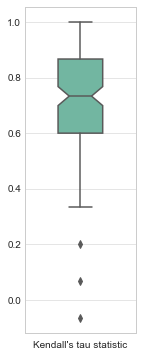

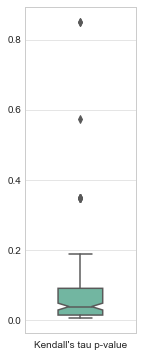

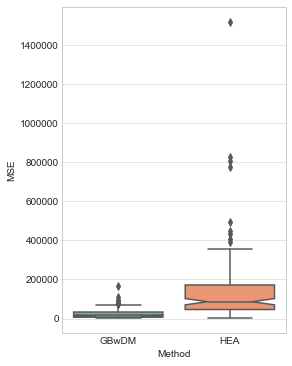

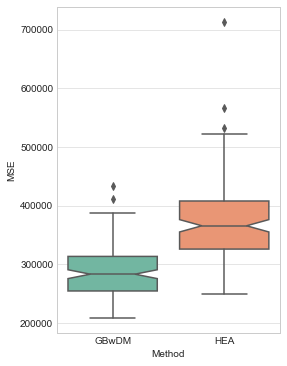

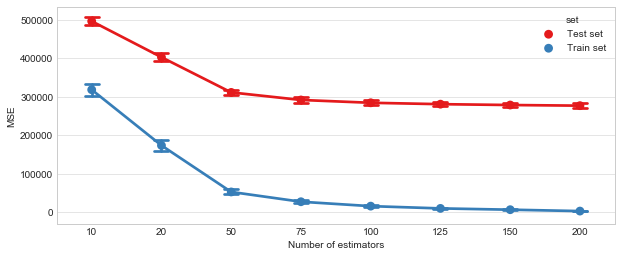

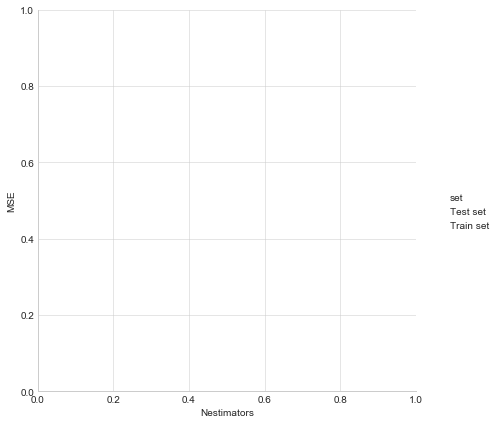

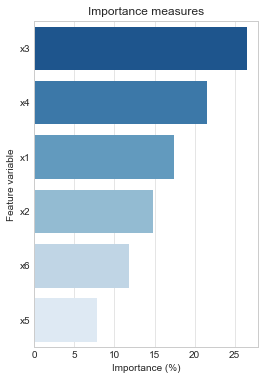

In [15]:

# Variable importance ranking Kendall's tau
data = pd.DataFrame(data=TAU, columns=['Kendall\'s tau statistic'])
f, ax = plt.subplots(figsize=(2, 6))
sns.boxplot(data, notch=True, width=0.4, palette = "Set2", orient='v', ax=ax)
ax.set_xlabel('Kendall\'s tau statistic')
print("Kendall's tau statistic median: {}".format(np.median(TAU)))

# Variable importance ranking test p-value
data = pd.DataFrame(data=PVAL, columns=['Kendall\'s tau p-value'])
f, ax = plt.subplots(figsize=(2, 6))
sns.boxplot(data, notch=True, width=0.4, palette = "Set2", orient='v', ax=ax)
ax.set_xlabel('Kendall\'s tau p-value')
print("Kendall's tau test p-value median: {}".format(np.median(PVAL)))
  
# Training MSE distribution
dataTr = pd.DataFrame(data=freqs[:,:,0].transpose(), columns=['GBwDM', 'HEA'])
dataTr['set'] = 'Training set'

# Testing MSE distribution
dataTe = pd.DataFrame(data=freqs[:,:,1].transpose(), columns=['GBwDM', 'HEA'])
dataTe['set'] = 'Testing set'

# Testing/Training MSE distribution (unified plot)
#s_data = dataTe.append(dataTr)
new_data1 = pd.DataFrame({'MSE':dataTr['GBwDM'], 'set':dataTr['set'], 'Method':'GBwDM'})
new_data1 = new_data1.append(pd.DataFrame({'MSE':dataTr['HEA'], 'set':dataTr['set'], 'Method':'HEA'}))
f, ax = plt.subplots(figsize=(4, 6))
sns.boxplot(x='Method', y='MSE', data=new_data1[new_data1['MSE']<1e20], palette = "Set2", notch=True, width=0.8)
new_data2 = pd.DataFrame({'MSE':dataTe['GBwDM'], 'set':dataTe['set'], 'Method':'GBwDM'})
new_data2 = new_data2.append(pd.DataFrame({'MSE':dataTe['HEA'], 'set':dataTe['set'], 'Method':'HEA'}))
f, ax = plt.subplots(figsize=(4, 6))
sns.boxplot(x='Method', y='MSE', data=new_data2[new_data2['MSE']<1e20], palette = "Set2", notch=True, width=0.8)

# Screen printing
print("WINS:\nGB:  %d\nST:  %d\n" % (gb_c, st_c))
print("FREQ max_features (0.5 = 'sqrt'):")
for k in mf_c:
  print("'{}' -> \t{}".format(k,mf_c[k]))
print("\nFREQ subsample:")
for k in ss_c:
  print("'{}' -> \t{}".format(k,ss_c[k]))
print("\nFREQ n_estimators:")
for k in ne_c:
  print("'{}' -> \t{}".format(k,ne_c[k]))
print("\nFREQ max_depth:")
for k in md_c:
  print("'{}' -> \t{}".format(k,md_c[k]))
print("\nMSE\tTrain\tTest\tIQR(test)\nGBwDM\t{:9.3f}\t{:9.3f}\t{:9.3f}\nHEA\t{:9.3f}\t{:9.3f}\t{:9.3f}".format(np.median(freqs[0,:,0]),np.median(freqs[0,:,1]), stats.iqr(freqs[0,:,1]),np.median(freqs[1,:,0]),np.median(freqs[1,:,1]), stats.iqr(freqs[1,:,1])))
print("\nMedian's test\tStat: {0[0]:9.3f}\tp-value: {0[1]:6.4f}".format(median_test(freqs[1,:,0],freqs[1,:,1])))

# MSE (test set) vs. Nestimators
f, ax = plt.subplots(figsize=(10, 4))
sns.factorplot(x='Nestimators', y="MSE", hue='set', data=MSErr, capsize=.2, palette = "Set1", size=6, ax=ax)
ax.set_ylabel('MSE')
ax.set_xlabel('Number of estimators')

# Plot feature importance
feature_importance = MODS['gb'].best_estimator_.feature_importances_   # From lastest seed
data = pd.DataFrame({'Variables':['x{}'.format(i) for i in range(1,7)], 'Importance':feature_importance*100})
data = data.sort_values(['Importance'], ascending=False).reset_index(drop=True)
sorted_idx = [x for _,x in zip(feature_importance, range(len(feature_importance)))] #np.argsort(feature_importance)
f, ax = plt.subplots(figsize=(4, 6))
sns.barplot(x='Importance', y='Variables', data=data, palette = "Blues_r", ax=ax)
ax.set_xlabel('Importance (%)')
ax.set_ylabel('Feature variable')
ax.set_title('Importance measures')

# Dumping weights of the heterogenous ensemble for posterior build
all_weights = pd.DataFrame()
all_weights = all_weights.append(pd.DataFrame({'Coef': weights[0,:], 'Base':'SVR', 'Case':SMP['case']}))
all_weights = all_weights.append(pd.DataFrame({'Coef': weights[1,:], 'Base':'LR', 'Case':SMP['case']}))
all_weights = all_weights.append(pd.DataFrame({'Coef': weights[2,:], 'Base':'MLP', 'Case':SMP['case']}))
all_weights = all_weights.append(pd.DataFrame({'Coef': weights[3,:], 'Base':'GPR', 'Case':SMP['case']}))
filename = 'rosenbrock_weights.pickle'
with open(filename, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(all_weights, f, pickle.HIGHEST_PROTOCOL)    

### Heterogeneous ensemble evaluation

['SVR', 'LinearRegression', 'MLPRegressor', 'GaussianProcessRegressor']

       Model	       MSE	     Bias2	  Variance
         SVR	1032197.953	707186.421	325011.532
LinearRegres	950102.869	705026.616	245076.253
MLPRegressor	1105033.653	704610.979	400422.674
GaussianProc	1208582.476	970951.472	237631.004
     Average	1073979.238	771943.872	302035.366


 Components:	        GErr	       Bias2	     1/M*Var	 (1-1/M)*Cov	         Sum
Ensemble MSE	911291.518264	771943.871881	75508.841494	109525.203728	956977.917103


<Figure size 720x720 with 0 Axes>

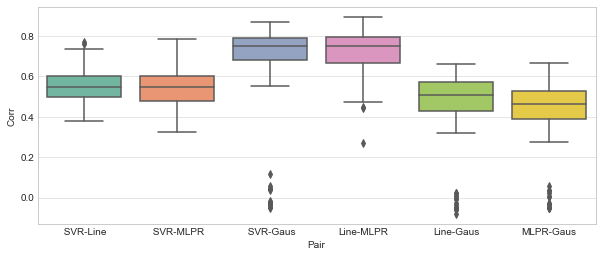

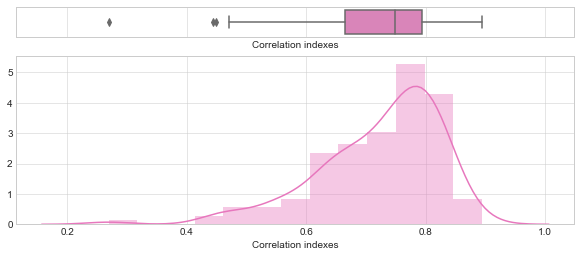

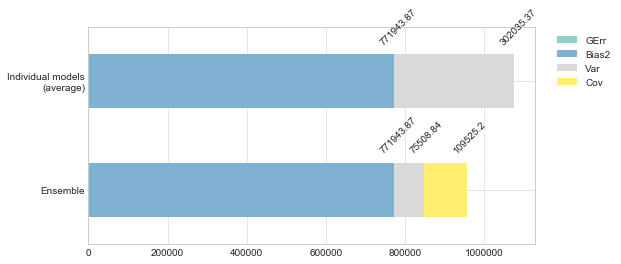

In [33]:

# Correlation analysis
regressors = MODS['sl_mr'].regr_
names = []
for cur_reg in regressors: 
  names.append(str(type(cur_reg)).split(sep='.')[-1].split(sep="'")[0])
print(names)    
Corrs = pd.DataFrame()
for i in range(4):
  for j in range(i+1,4):
    Corrs = Corrs.append(pd.DataFrame({'Corr':CORR[i,j,:], 'Pair':'%4s-%4s'%(names[i][:4],names[j][:4])}), ignore_index=True)
fig = plt.figure(figsize=(10, 10))
f1, ax1 = plt.subplots(figsize=(10, 4))
sns.boxplot(x="Pair", y="Corr", data=Corrs, palette = "Set2")

# Most correlated close-up
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(10, 4))
data = pd.Series(CORR[1,2,:], name="Correlation indexes")
sns.distplot(data, color='#e777bd', ax=ax_hist) 
sns.boxplot(data, color='#e777bd', ax=ax_box)

# Ensamble's error decomposition
# MSE decomposition
gmse  = lambda estims: np.average((estims - np.matmul(np.reshape(SMP['ytest'],(tr_dim,1)),np.ones(shape=(1,boots))))**2, axis=1)
bias2 = lambda estims: np.average((estims - np.matmul(np.reshape(SMP['ytest'],(tr_dim,1)),np.ones(shape=(1,boots)))), axis=1)**2
varia = lambda estims: np.average((estims - np.matmul(np.reshape(np.average(estims, axis=1),(tr_dim,1)),np.ones(shape=(1,boots))))**2, axis=1)
covar = lambda estims1, estims2: np.average( \
               (estims1 - np.matmul(np.ones(shape=(tr_dim,1)),np.reshape(np.average(estims1, axis=0),(1,boots)))) * \
               (estims2 - np.matmul(np.ones(shape=(tr_dim,1)),np.reshape(np.average(estims2, axis=0),(1,boots)))), axis=1)

# Per model factors
MSE = []
BIAS = []
VAR = []
COVAR = []
idx = 0
print("\n%12s\t%10s\t%10s\t%10s"%("Model","MSE","Bias2","Variance"))
for cur in names:
  MSE.append(np.mean(gmse(spc_preds[cur])))
  BIAS.append(np.mean(bias2(spc_preds[cur])))
  VAR.append(np.mean(varia(spc_preds[cur])))
  print("%12s\t%10.3f\t%10.3f\t%10.3f"%(cur[:12],MSE[idx],BIAS[idx],VAR[idx]))
  idx += 1
print("%12s\t%10.3f\t%10.3f\t%10.3f\n"%("Average",np.mean(MSE),np.mean(BIAS),np.mean(VAR)))
idx = 0
for col in names:
  for row in names[idx+1:]:
    COVAR.append(covar(spc_preds[col],spc_preds[row]))
  idx += 1

perBootMSE = gmse(eqw_preds)
perBootBIAS = bias2(spc_preds[cur])
perBootVAR = varia(spc_preds[cur])
  
print("\n%12s\t%12s\t%12s\t%12s\t%12s\t%12s"%("Components:","GErr","Bias2","1/M*Var","(1-1/M)*Cov", "Sum"))
print("%12s\t%12f\t%12f\t%12f\t%12f\t%12f"%("Ensemble MSE",np.mean(perBootMSE),np.mean(BIAS), 1/4*np.mean(VAR),(1-1/4)*np.mean(COVAR), \
                                            np.mean(BIAS) + 1/4*np.mean(VAR) + (1-1/4)*np.mean(COVAR)))
# We want bars...
datos = pd.DataFrame(np.transpose(np.transpose([[0, np.mean(BIAS), 0.25*np.mean(VAR), 0.75*np.mean(COVAR)], \
                                               [0, np.mean(BIAS), np.mean(VAR), 0]])), \
                     columns=['GErr', 'Bias2', 'Var', 'Cov'], \
                     index=['Ensemble', 'Individual models\n(average)'])
f, ax = plt.subplots(figsize=(8, 4))
datos.plot.barh(stacked=True, colormap='Set3', ax=ax);
horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
for p in ax.patches: 
  if p.get_width() < 1:
    continue
  ax.annotate(np.round(p.get_width(),decimals=2), (p.get_x()+p.get_width(), p.get_y()+p.get_height()/2), \
              ha='left', va='bottom', xytext=(-15, 35), textcoords='offset points', \
              family='sans-serif', rotation=45)

In [ ]:
print(Corrs)